### Spam or not CNN

In [1]:
import gensim.downloader as api
import numpy as np
import os
import shutil
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
import logging
tf.get_logger().setLevel(logging.ERROR)
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
# tensorflow-2.5, numpy-1.19.5 are compatible with python-3.9

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Defines functions
# Get data
def download_and_read(url):
    local_file = url.split('/')[-1]
    p = tf.keras.utils.get_file(local_file, url, 
        extract=True, cache_dir=".")
    labels, texts = [], []
    local_file = os.path.join("datasets", "SMSSpamCollection")
    with open(local_file, "r") as fin:
        for line in fin:
            label, text = line.strip().split('\t')
            labels.append(1 if label == "spam" else 0)
            texts.append(text)
    return texts, labels

# Build embedding matrix
def build_embedding_matrix(sequences, word2idx, embedding_dim, 
        embedding_file):
    if os.path.exists(embedding_file):
        E = np.load(embedding_file)
    else:
        vocab_size = len(word2idx)
        E = np.zeros((vocab_size, embedding_dim))
        word_vectors = api.load(EMBEDDING_MODEL)
        for word, idx in word2idx.items():
            try:
                E[idx] = word_vectors.word_vec(word)
            except KeyError:   # word not in embedding
                pass
            # except IndexError: # UNKs are mapped to seq over VOCAB_SIZE as well as 1
            #     pass
        np.save(embedding_file, E)
    return E

# Model class
class SpamClassifierModel(tf.keras.Model):
    def __init__(self, vocab_sz, embed_sz, input_length,
            num_filters, kernel_sz, output_sz, 
            run_mode, embedding_weights, 
            **kwargs):
        super(SpamClassifierModel, self).__init__(**kwargs)
        if run_mode == "scratch":
            self.embedding = tf.keras.layers.Embedding(vocab_sz, 
                embed_sz,
                input_length=input_length,
                trainable=True)
        elif run_mode == "vectorizer":
            self.embedding = tf.keras.layers.Embedding(vocab_sz, 
                embed_sz,
                input_length=input_length,
                weights=[embedding_weights],
                trainable=False)
        else:
            self.embedding = tf.keras.layers.Embedding(vocab_sz, 
                embed_sz,
                input_length=input_length,
                weights=[embedding_weights],
                trainable=True)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.conv = tf.keras.layers.Conv1D(filters=num_filters,
            kernel_size=kernel_sz,
            activation="relu")
        self.pool = tf.keras.layers.GlobalMaxPooling1D()
        self.dense = tf.keras.layers.Dense(output_sz, 
            activation="softmax"
        )

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.conv(x)
        x = self.pool(x)
        x = self.dense(x)
        return x

In [3]:
# Initialize variables
DATA_DIR = "datasets"
EMBEDDING_NUMPY_FILE = os.path.join(DATA_DIR, "E.npy")
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
EMBEDDING_MODEL = "glove-wiki-gigaword-300"
EMBEDDING_DIM = 300
NUM_CLASSES = 2
BATCH_SIZE = 128
NUM_EPOCHS = 3

# Number of ham are 8x more than spam
CLASS_WEIGHTS = { 0: 1, 1: 8 }

tf.random.set_seed(42)

# Choices= "scratch", "vectorizer", "finetuning"
run_mode = "finetuning"

In [4]:
# Prepare data
texts, labels = download_and_read(DATASET_URL)

# tokenize and pad text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences)
num_records = len(text_sequences)
max_seqlen = len(text_sequences[0])
print("{:d} sentences, max length: {:d}".format(num_records, max_seqlen))

# Labels
cat_labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)

# Vocabulary
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
word2idx["PAD"] = 0
idx2word[0] = "PAD"
vocab_size = len(word2idx)
print("vocab size: {:d}".format(vocab_size))

# Split dataset
dataset = tf.data.Dataset.from_tensor_slices((text_sequences, cat_labels))
dataset = dataset.shuffle(10000)
test_size = num_records // 4
val_size = (num_records - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

5574 sentences, max length: 189
vocab size: 9010


2021-09-22 22:31:24.468415: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 22:31:24.468813: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# embedding
E = build_embedding_matrix(text_sequences, word2idx, EMBEDDING_DIM,
    EMBEDDING_NUMPY_FILE)
print("Embedding matrix:", E.shape)

Embedding matrix: (9010, 300)


### Embedding matrix shape depends on the chosen 3rd party embedding

In [6]:
# model definition
conv_num_filters = 256
conv_kernel_size = 3
model = SpamClassifierModel(
    vocab_size, EMBEDDING_DIM, max_seqlen, 
    conv_num_filters, conv_kernel_size, NUM_CLASSES,
    run_mode, E)
model.build(input_shape=(None, max_seqlen))
model.summary()

# compile and train
model.compile(optimizer="adam", loss="categorical_crossentropy",
    metrics=["accuracy"])

# train model
model.fit(train_dataset, epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    class_weight=CLASS_WEIGHTS)

# evaluate against test set
labels, predictions = [], []
for Xtest, Ytest in test_dataset:
    Ytest_ = model.predict_on_batch(Xtest)
    ytest = np.argmax(Ytest, axis=1)
    ytest_ = np.argmax(Ytest_, axis=1)
    labels.extend(ytest.tolist())
    predictions.extend(ytest.tolist())

print("test accuracy: {:.3f}".format(accuracy_score(labels, predictions)))


Model: "spam_classifier_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2703000   
_________________________________________________________________
spatial_dropout1d (SpatialDr multiple                  0         
_________________________________________________________________
conv1d (Conv1D)              multiple                  230656    
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  514       
Total params: 2,934,170
Trainable params: 2,934,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
     29/Unknown - 32s 1s/step - loss: 0.3753 - accuracy: 0.8605

2021-09-22 22:31:57.464346: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


29/29 [==============================] - 34s 1s/step - loss: 0.3753 - accuracy: 0.8605 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
28/29 [===========================>..] - ETA: 1s - loss: 0.0733 - accuracy: 0.9757

2021-09-22 22:32:29.172771: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


29/29 [==============================] - 31s 1s/step - loss: 0.0733 - accuracy: 0.9763 - val_loss: 0.0508 - val_accuracy: 0.9870
Epoch 3/3
28/29 [===========================>..] - ETA: 1s - loss: 0.0471 - accuracy: 0.9869

2021-09-22 22:32:59.766407: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


29/29 [==============================] - 31s 1s/step - loss: 0.0471 - accuracy: 0.9871 - val_loss: 0.0274 - val_accuracy: 0.9948
test accuracy: 1.000


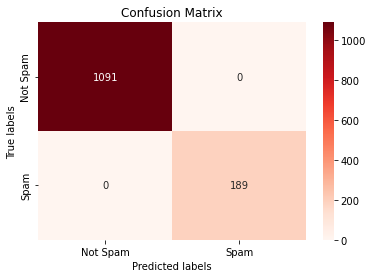

In [7]:
ax= plt.subplot()

#annot=True to annotate cells
sns.heatmap(confusion_matrix(labels, predictions), annot=True, ax = ax,cmap='Reds',fmt='');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [8]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =189,
                      padding = "post",
                      truncating="post")
    return (model.predict(padded))

In [25]:
predict_msg = ["You won a Sony Television! Call now", "What time is the movie?", "local single click here junk dick"]

predict_spam(predict_msg)

array([[0.17164844, 0.82835156],
       [0.9901779 , 0.00982209],
       [0.971704  , 0.02829599]], dtype=float32)